In [1]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

In [2]:
# Create an environment
env = gym.make('MountainCar-v0')
env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State space: Box(2,)
- low: [-1.2  -0.07]
- high: [0.6  0.07]
Action space: Discrete(3)


/home/jim/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    print("Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>")
    for l, h, b, o, splits in zip(low, high, bins, offsets, grid):
        print("    [{}, {}] / {} + ({}) => {}".format(l, h, b, o, splits))
    return grid

In [4]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension
#     return list(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension


In [5]:
grid = create_tiling_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")
print(type(grid))
grid

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]

Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])
<class 'list'>


[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

In [6]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    # TODO: Implement this
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]


In [7]:
from matplotlib.lines import Line2D

# import pdb

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
#     pdb.set_trace()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    return ax  # return Axis object to draw on later, if needed


In [8]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])

    

In [9]:
def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    # TODO: Implement this
#     encoded_sample = [discretize(sample, grid) for grid in tilings]
#     encoded_sample = discretize(sample, tilings)
    encoded_sample = list(discretize(sample, tilings))
    return np.concatenate(encoded_sample) if flatten else encoded_sample

In [24]:
import pdb
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size

        # TODO: Create Q-table, initialize all Q-values to zero
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("QTable(): size =", self.q_table.shape)


class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s).
        
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tiling_grid() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
#         pdb.set_trace()

#         self.tilings = create_tilings(low, high, tiling_specs)
        self.tilings = create_tiling_grid(low, high)
#         self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.state_sizes = tuple(len(splits) + 1 for splits in self.tilings)
        self.action_size = action_size
#         self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        self.q_tables = QTable(self.state_sizes, self.action_size)
#         self.q_tables = np.zeros(shape=(self.state_sizes + (self.action_size,)))
#         self.q_tables = np.zeros(shape=(self.state_sizes + (self.action_size,))).tolist()
#         print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # TODO: Encode state to get tile indices
#         pdb.set_trace()
        encoded_state = tile_encode(state, self.tilings)
#         encoded_state = np.array([discretize(sample, self.tilings) for sample in state])
        # TODO: Retrieve q-value for each tiling, and return their average
        value = 0.0
        for idx, q_table in zip(encoded_state, self.q_tables):
#             value += q_table.q_table[tuple(idx + (action,))]
            value += q_table[tuple(idx + (action,))]
#             value += q_table[idx + (action,)]

# (tuple(encoded_state) + (action,))

        value /= len(self.q_tables)
        return value
    
    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        # TODO: Update q-value for each tiling by update factor alpha
        for idx, q_table in zip(encoded_state, self.q_tables):
#             value_ = q_table.q_table[tuple(idx + (action,))]  # current value
            value_ = q_table[tuple(idx + (action,))]  # current value
            q_table.q_table[tuple(idx + (action,))] = alpha * value + (1.0 - alpha) * value_



# # Test with a sample Q-table
# tq = TiledQTable(low, high, tiling_specs, 2)
# s1 = 3; s2 = 4; a = 0; q = 1.0
# print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value at sample = s1, action = a
# print("[UPDATE] Q({}, {}) = {}".format(samples[s2], a, q)); tq.update(samples[s2], a, q)  # update value for sample with some common tile(s)
# print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value again, should be slightly updated

In [25]:
import pdb
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, tq, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=0):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.tq = tq 
        self.q_table = tq.q_tables
        self.state_sizes = tq.state_sizes           # list of state sizes for each tiling
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space sizes:", self.state_sizes)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate   # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = state
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        # Pick the best action from Q table
        greedy_action = np.argmax(Q_s)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = greedy_action
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            value = reward + self.gamma * max(Q_s)
            self.tq.update(self.last_state, self.last_action, value, self.alpha)

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the greedy action
                action = greedy_action

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

In [26]:
n_bins = 10
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)

tiling_specs = [(bins, tuple([0.0]*env.observation_space.shape[0]))]

tq = TiledQTable(env.observation_space.low, 
                 env.observation_space.high, 
                 tiling_specs, 
                 env.action_space.n)
agent = QLearningAgent(env, tq)


Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 10 + (0.0) => [-1.02 -0.84 -0.66 -0.48 -0.3  -0.12  0.06  0.24  0.42]
    [-0.07000000029802322, 0.07000000029802322] / 10 + (0.0) => [-0.056 -0.042 -0.028 -0.014  0.     0.014  0.028  0.042  0.056]
QTable(): size = (10, 10, 3)
Environment: <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State space sizes: (10, 10)
Action space size: 3


In [27]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])

    
# state_samples = np.array([env.observation_space.sample() for i in range(10)])
# discretized_state_samples = np.array([discretize(sample, tilings) for sample in state_samples])
# visualize_samples(state_samples, discretized_state_samples, tilings, env.observation_space.low, env.observation_space.high)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 10 + (0.0) => [-1.02 -0.84 -0.66 -0.48 -0.3  -0.12  0.06  0.24  0.42]
    [-0.07000000029802322, 0.07000000029802322] / 10 + (0.0) => [-0.056 -0.042 -0.028 -0.014  0.     0.014  0.028  0.042  0.056]


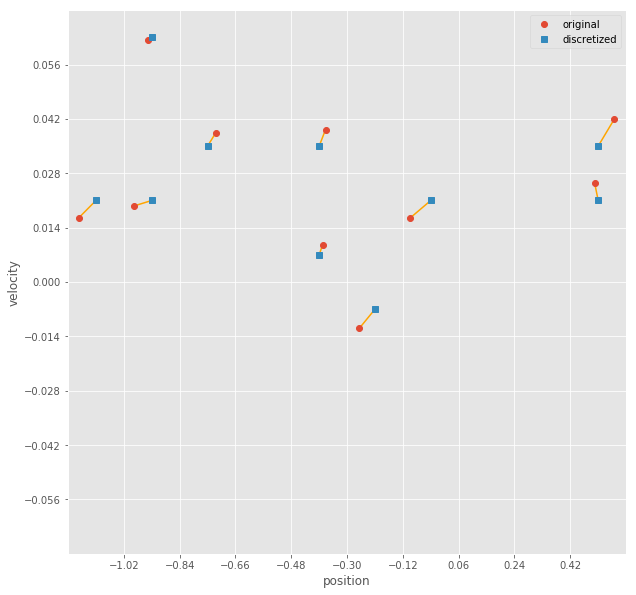

In [31]:
# state_grid = tilings
state_grid = create_tiling_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))
# state_grid = TiledQTable.tilings


# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
visualize_samples(state_samples, discretized_state_samples, state_grid,
                  env.observation_space.low, env.observation_space.high)
plt.xlabel('position'); plt.ylabel('velocity');  # axis labels for MountainCar-v0 state space

In [32]:
def run(agent, env, num_episodes=10000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)

        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()
    return scores

scores = run(agent, env)

TypeError: zip argument #2 must support iteration

In [71]:
agent.q_table

In [73]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(agent.q_table)

AxisError: axis 2 is out of bounds for array of dimension 1